In [1]:
%load_ext autoreload
%autoreload 2

# Part 1: Functional Interpolation $ y = f(x) $

## Lagrange Interpolating Polynomial
We will start with Lagrange interpolation.

Given a set of $ n+1 $ control points $(x_0, y_0), (x_1, y_1), \ldots, (x_n, y_n)$, the Lagrange interpolating polynomial $ P_n(x) $ of degree $ n $ is defined as follows:

$P_n(x) = \sum_{i=0}^{n} y_i \ell_i(x)$

where $\ell_i(x) $ is the Lagrange polynomial associated with the $i$-th control point, given by:

$ \ell_i(x) = \prod_{\substack{0 \le j \le n \\ j \ne i}} \frac{x - x_j}{x_i - x_j} $

### Example with 3 Points

$P_2(x) = y_0 \frac{(x - x_1)(x - x_2)}{(x_0 - x_1)(x_0 - x_2)} + y_1 \frac{(x - x_0)(x - x_2)}{(x_1 - x_0)(x_1 - x_2)} + y_2 \frac{(x - x_0)(x - x_1)}{(x_2 - x_0)(x_2 - x_1)}$

## Complications

When testing random samples with a variable number of control points, try to identify problematic cases.
Attempt to understand what causes these issues, particularly in relation to the faithful interpolation of control points.

The color scale is as follows: blue - close to control points / yellow - far from control points.

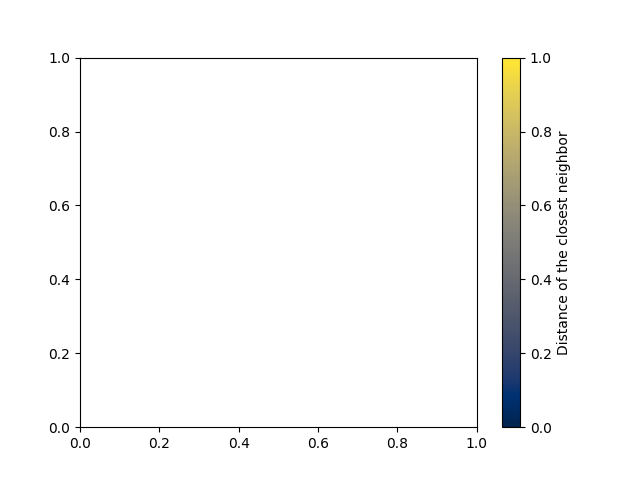

In [2]:
from utilities import *

%matplotlib ipympl
graph_interface()

### Remark on Control Points

You will notice that if two control points have very close abscissas but very different ordinates, the interpolating polynomial can then take values far from the control points. Indeed, this configuration forces the polynomial to have a high local derivative given by:

$ f'(x_i) = \frac{y_{i+1} - y_i}{x_{i+1} - x_i} $

This leads to very significant oscillations.

Button(description='Reset Animation', style=ButtonStyle())

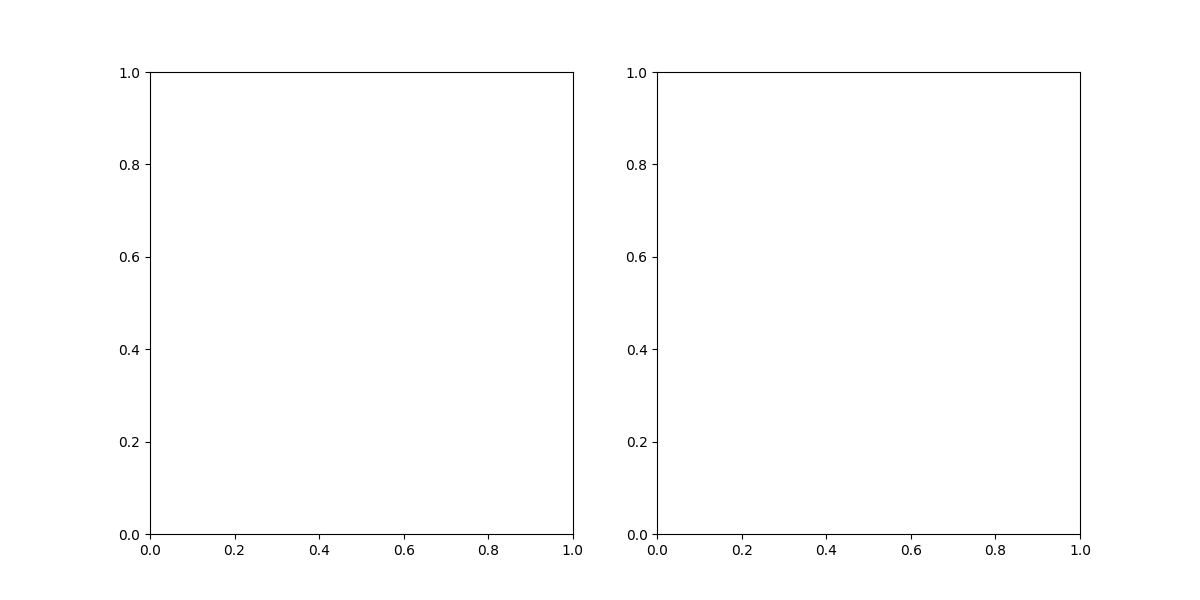

In [3]:
from utilities import *

%matplotlib ipympl

anim_manager = AnimationManager()
anim_manager.create_animation()

## Neville's Algorithm

Neville's algorithm is a polynomial interpolation method that allows finding an interpolated value for a given $ t$ using data points $ (X_i, Y_i) $. Beware that we are here in the functionnal setting. Here is a detailed explanation of the algorithm:

1. **Initialization**:
    - Let $ X = [X_0, X_1, ..., X_n]$ be the abscissas of the data points.
    - Let $ Y = [Y_0, Y_1, ..., Y_n]$ be the ordinates of the data points.
    - Let $ x $ be the value for which we want to interpolate.

2. **Neville's Table**:
    - Neville's algorithm computes row by row a table $ P$ of dimension $ (n+1) \times (n+1)$ where $ P[i][j]$ represents the interpolated value obtained using the points $ (X_i, Y_i), (X_{i+1}, Y_{i+1}), ..., (X_{i+j}, Y_{i+j})$ for the value $ x$.
    - As seen in class, you do not need to create the table but Neville's algorithm can be computed **in place**, that is, computation of the new row replaces the old row. Below we explain the algorithm on the grid, but be sure that your implementation does not use more than a vector of $O(n)$ values to store the computation. 

3. **Initialization of the First Column**:
    - For each $ i$ from 0 to $ n$:
      $
      P[i][0] = Y_i
      $

4. **Calculation of the Other Columns**:
    - For each $ j$ from 1 to $ n$:
        - For each $ i$ from 0 to $ n-j$:
          $
          P[i][j] = \frac{(X_{i+j} - x) \cdot P[i][j-1] + (x - X_i) \cdot P[i+1][j-1]}{X_{i+j} - X_i}
          $

5. **Result**:
    - The interpolated value for $x$ is given by $ P[0][n]$.


This algorithm efficiently finds an interpolated value using Neville's polynomial interpolation.

### Implementation:

In the file `interpolation.py`, complete the code for the `neville` function:

```python
def neville(XX, YY, x):
```

Then, test this function. The interpolated curve obtained should be identical to that of Lagrange.

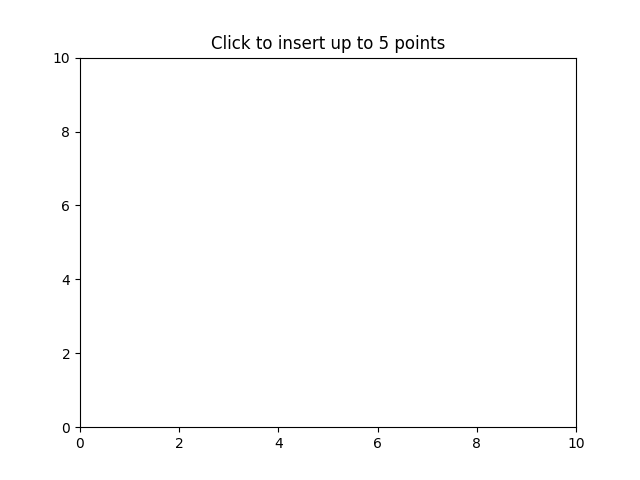

In [6]:
from utilities import *
%matplotlib ipympl

try :
    NevilleInterpolation((0, 10), (0, 10), 5)
except Exception as e:
        print("An error occurred:")
        traceback.print_exc()
        print(f"Exception type: {type(e).__name__}")
        print(f"Exception description: {e}")
clear_output(wait=True)

## Comparison Neville - Lagrange



Neville's algorithm is more computationally efficient than Newtonian interpolation when the number of points to evaluate is small (generally less than the number of interpolation points). 

Let's plot the computation time as a function of the number of evaluation points, while keeping a fixed number of control points.

Calcul des différences: 100%|██████████████████████████████████████████████████████████| 15/15 [00:11<00:00,  1.34it/s]


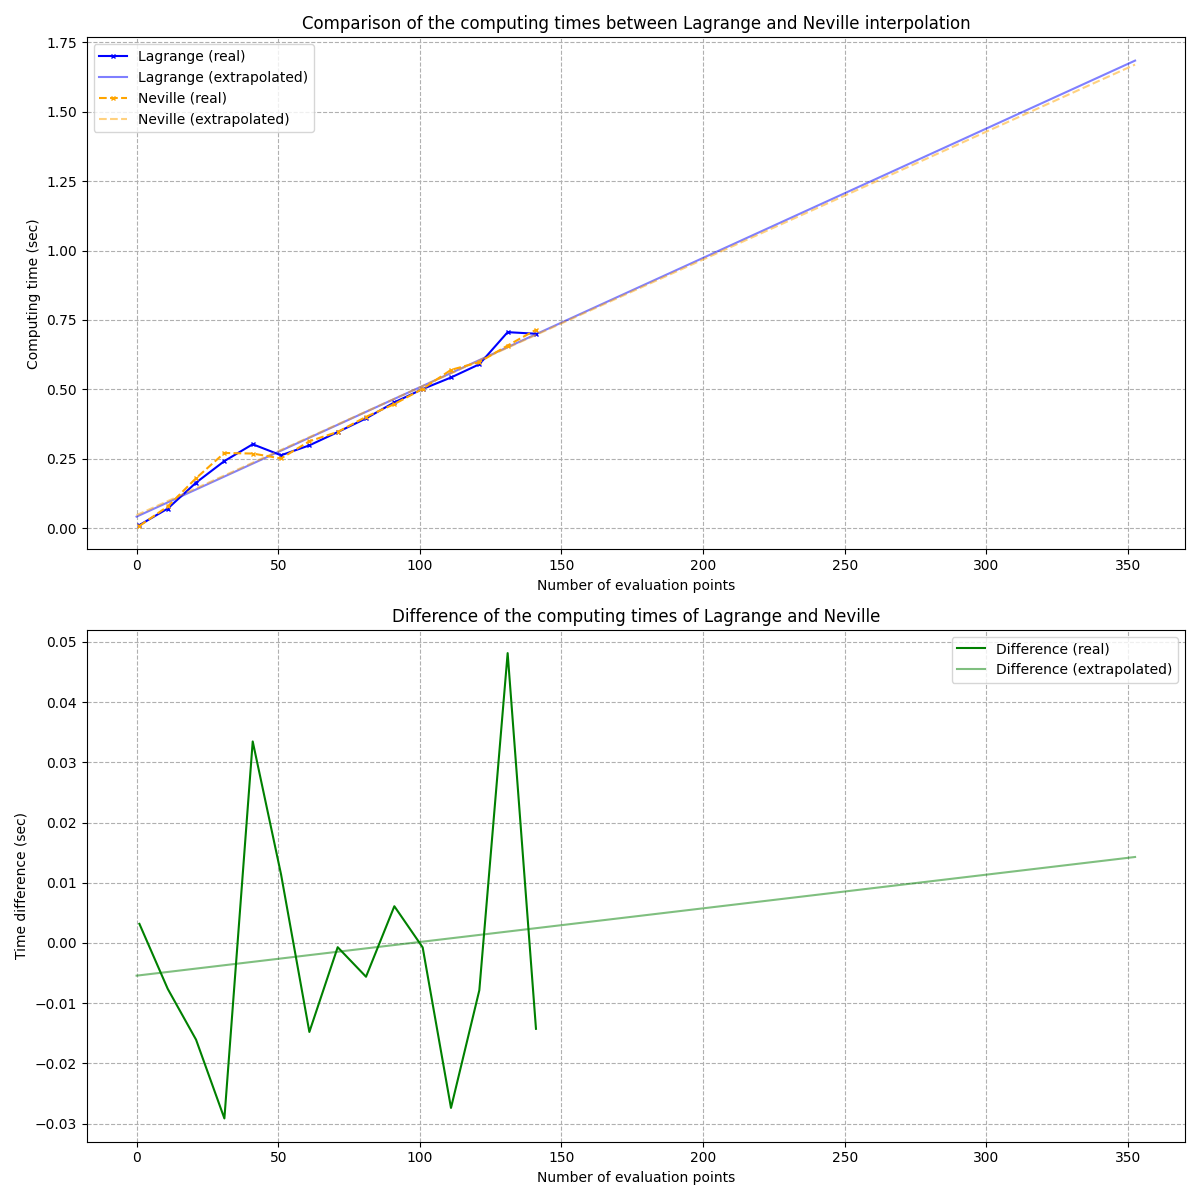

In [7]:
from utilities import *


nb_pts = 100
start = 1
end = 150
step = 10

compare_interpolation_times(nb_pts, start, end, step)


Let's also plot the computation time as a function of the number of control points, while keeping a fixed number of evaluation points.

Computing differences: 100%|███████████████████████████████████████████████████████████| 15/15 [00:11<00:00,  1.32it/s]


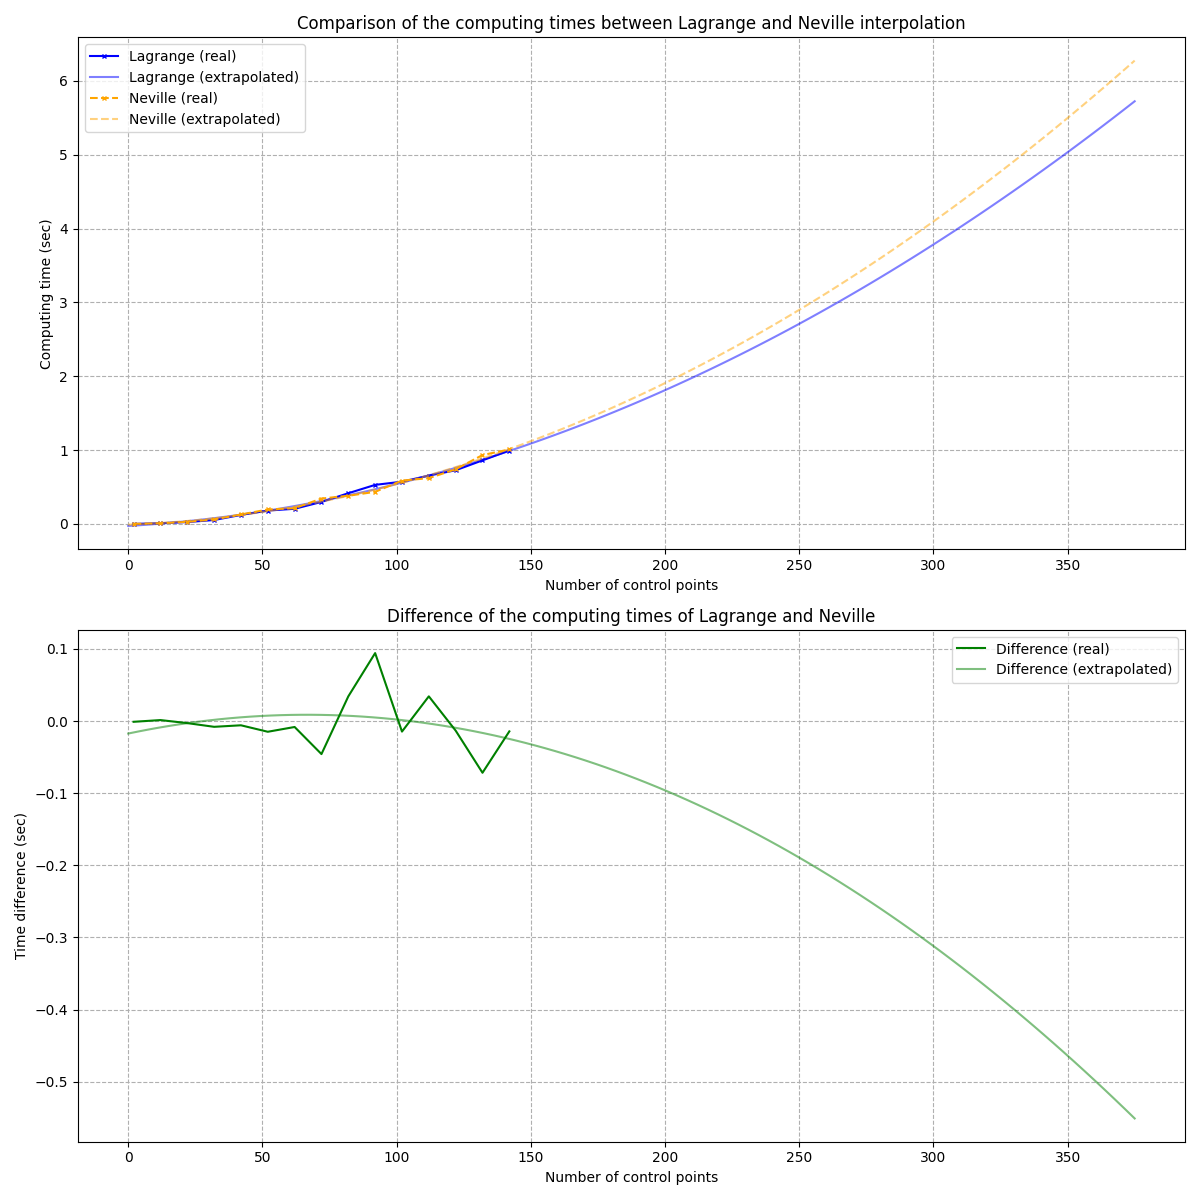

In [8]:
from utilities import *


fixed_evaluation_points = 100
start = 2
end = 150
step = 10
compare_interpolation_times_2(fixed_evaluation_points, start, end, step)

In all cases, Neville's method is more efficient than Lagrange's method for a large number of control and evaluation points.

#### Therefore, we will use Neville's method for the rest of the lab.

## Formalization of Oscillations

This problem can be formalized. Indeed, if we consider a function $f(x)$ and place points at regular intervals on the curve $C_f$, then the maximum deviation between the function and its interpolation increases indefinitely with the number of points $n$. This phenomenon was discovered and formalized by the German mathematician Carl Runge:

$ \lim_{{n \to \infty}} \max_{x} |f(x) - P_n(x)| \to \infty $

### Short Explanation

By repeated applications of Rolle's theorem, it can be shown that for the case of interpolation with $ n + 1 $ evenly spaced points, there exists a point $ \xi \in ]-1, 1[ $ such that

$ f(x) - P_n(x) = \frac{f^{(n+1)}(\xi)}{(n+1)!} \prod_{i=0}^{n}(x - x_i). $

In the chosen example, the values of the successive derivatives of the function increase with the number of points, thus the oscillations between each interpolation point amplify.

Moreover, when the interpolation nodes are evenly spaced, this situation worsens, as explained below. Indeed, in a more general setting, Lagrangian interpolation on equidistant nodes is not optimal. Denoting $(l_i)$ as the basis of Lagrange polynomials related to the points $(x_i)$, we have:

$ P_n(x) = \sum_{i=0}^{n} f(x_i) l_i(x), $

from which the following estimation can be derived:

$ |P_n(x)| \leq \left(\sum_{i=0}^{n} |l_i(x)|\right) \|f\|_{\infty} \leq \sup_{x \in [a, b]} \left(\sum_{i=0}^{n} |l_i(x)|\right) \|f\|_{\infty}. $

The constant

$ \Lambda_n = \sup_{x \in [a, b]} \left(\sum_{i=0}^{n} |l_i(x)|\right) $

is called the Lebesgue constant associated with the points $(x_i)$. It is important to note that the Lebesgue constant depends only on the interpolation nodes (it is independent of the function to be interpolated). In the case of equidistant points, this constant can be estimated by:

$ \Lambda_n \sim \frac{2^{n+1}}{e \, n \ln(n)}, $

with $ e $ (Euler's number). Thus, we see that in this case, the Lebesgue constant quickly tends to large values.

### Example

Consider the following function:

$ f(x) = \frac{1}{1 + 25x^2} $

We consider $(n + 1)$ evenly spaced points in the segment $[-1, 1]$:
$ x_0 = -1, \quad x_1 = x_0 + h, \quad \ldots, \quad x_k = x_0 + (k+1)h, \quad x_n = 1, \quad \text{with} \quad h = \frac{2}{n} $

Finally, we consider the interpolating polynomial of $ f $ at the points $ (x_i) $, i.e., the unique polynomial $ P_n $ of degree less than or equal to $ n $ such that $ P_n(x_i) = f(x_i) $ for all $ i $. We denote this polynomial by $ P_n $.

Runge showed that the interpolation error between $ P_n $ and $ f $ tends to infinity as $ n $ increases. In other words, the more points we fix where the polynomial has the same value as $ f $, the worse we approximate the function.

In [ ]:
from utilities import *

%matplotlib widget

visualizer = InterpolationVisualizer(start_points=10, end_points=35)
visualizer.display()

### Solution

We can minimize the oscillation of interpolating polynomials by using Chebyshev nodes instead of equally spaced points for interpolation. In this case, it can be shown that the interpolation error (i.e., $\max_{-1 \leq x \leq 1} |f(x) - P_n(x)|$) decreases as $ n $ increases.

For any positive integer $ n $, the coefficients are given by:

$ a_k^{(n)} = \cos \left( \frac{(2k-1)\pi}{2n} \right), \quad \forall k \in \{1, \ldots, n\} $

### Objective:

In the file `interpolation.py`, complete the code for the `tchebycheff_parametrisation` function:

```python
def tchebycheff_parametrisation(nb_point: int) -> List[float]:
```

This function calculates the Chebyshev nodes for a given number of points, which can then be used for interpolation to minimize the oscillations.

In [ ]:
from utilities import *


test_tchebycheff_parametrisation()

#### Let's see what happens with a Chebyshev distribution:

In [ ]:
from utilities import *


vis = InterpolationVisualizer_2(start_points=6, end_points=30)
vis.display()

# Before leaving the notebook, make sure to clear all the outputs !